# Data Augmentation

This notebook is a learning note of the data augmentations for LIDC-IDRI dataset, aligned with the BYOL method, written by Ying Liu.

In this notebook, the code will be provided by the order of the original augmentation steps, with the thoughts about what kind of modifications should be made to suit my medical image data.

In [1]:
import numpy as np
import pylidc as pl
import torchio as tio
import SimpleITK as sitk
import matplotlib.pyplot as plt

e:\master-thesis\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Random Cropping

[The original description - BYOL](https://arxiv.org/pdf/2006.07733.pdf), a random patch of the image is selected, with an area uniformly sampled between $8\%$ and $100\%$ of that of the original image, and an aspect ratio logarithmically sampled between $3/4$ and $4/3$. This patch is then resized to the target size of $224\times 224$ using bicubic interpolation;

My current preprocessed image is a 3DCT with the shape of (320, 320, 320) from the center cropped step in the preprocess notebook.

<font color=red>***Question**: First, how to understand a patch of the image in my case?*</font>

Patch: image patch is a container of pixels in larger form, and this word is interchangeble with the word "window". A patch is small (generally rectangular) piece of an image. My understanding is that a 3D patch is a 3D window of the image, which is a 3D volume of the image. <I>The width and height of the 3D patch is smaller than the 3D image, but what about depth.</I> ==> <font color=red>***Confused**: How to select patch? Interested region covered?*</font>

I forgot where 25% should be used, whether for the aspect ratio or the area of the patch, due to the medical images are different from natrual images. For now, I am going to take it for the aspect ratio. ==> i.e., resample the range of $0.25 \pm 1.0$ on the original image.

Aspect ratio: The ratio of its sizes in different dimensions. For example, the aspect ratio of a rectangle is the ratio of its longer side to its shorter side - the ratio of width to height. Here is one guy posted: Aspect ratio is its size along y-axis divided by its size along x-axis. https://se.mathworks.com/matlabcentral/answers/237-how-to-compute-volume-and-aspect-ratio-of-a-3d-geometry

The patch should be then resized to the target size of $128\times 128 \times 128$ in my case.

Through this post, https://f-i-tushar-eee.medium.com/3d-data-augmentation-using-tf-data-and-volumentations-3d-library-9452c2fcc1a7, the author suggests to use the library for processing 3D volumes https://github.com/ZFTurbo/volumentations?tab=readme-ov-file. I am going to try the built-in function called randomresizedcrop ==> For this library, tried but not work. Therefore, going to develop my own function by using torchio.

The following is my workflow, by using torchio
- load sitk image with the shape of (320, 320, 320)
- randomly crop the portion out of the image (x, y, 320)
- resize (resample) the cropped portion by using 1.0 +/- 0.25 randomly
- use the 3D box to crop the image to the target size of (128, 128, 128)

### V1

- the workflow is as follows: torchio
- randomly crop the original image to a patch by the area of (25% ~ 100%)
- resample the cropped image by the factor of (0.75 ~ 1.25)
- generate a 3D box with the shape of (128, 128, 128) to contain the resampled image
- the final image is the cropped resampled image with the shape of (128, 128, 128) 

In [3]:
class RandomResizedCrop(tio.Transform):
    def __init__(self, size, scale=(0.25, 1.0), aspect_ratio=(0.75, 1.33)):
        super().__init__()
        self.size = self.parse_size(size)
        self.scale = scale
        self.aspect_ratio = aspect_ratio
        
    def apply_transform(self, subject):
        image = subject['image'] # shape: (c, z, x, y)
        # randomly crop the original image to a patch by the area of (25% ~ 100%) -> (x, y, 320)
        cropped = self.random_crop(image, self.scale)
        # resample the cropped image by the factor of (0.75 ~ 1.25)
        resampled = self.random_resample(cropped)
        # generate a 3D box with the shape of (128, 128, 128) to contain the resampled image
        patch = self.generate_patch(resampled)
        subject['image'] = patch
        return subject
        
    def random_crop(self, image, scale):
        scale_factor = np.random.uniform(*scale)
        # crop for x, y axis for all slices and crop for z axis for 320 slices
        cropped = tio.CropOrPad(int(scale_factor*image.shape[1]), int(scale_factor*image.shape[2]))(image)
        return cropped
    
    def random_resample(self, image):
        aspect_ratio = np.random.uniform(*self.aspect_ratio)
        print(aspect_ratio)
        # resample for each direction
        resampled = tio.Resample((aspect_ratio, aspect_ratio, aspect_ratio), image_interpolation='bspline')(image)
        return resampled
    
    def generate_patch(self, image):
        # generate a 3D box with the shape of (128, 128, 128) to contain the resampled image
        # pad with the minimum value of the image
        data = image.data
        minimum = data.min()
        patch = tio.CropOrPad(self.size, padding_mode=int(minimum))(image) # This is not random, integrate random
        
        return patch
    
    def parse_size(self, size):
        if isinstance(size, int):
            return (size, size, size)
        elif isinstance(size, tuple):
            return size
        else:
            raise ValueError(f'Invalid size: {size}')

#### Visualization

0.9458509504431594


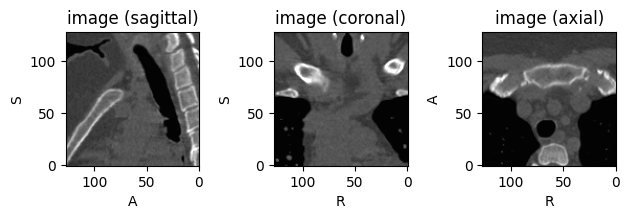

In [6]:
image = tio.ScalarImage('E:/master-thesis/preprocess/test-results/center_cropped_image_xyz.nii.gz')
subject = tio.Subject(image=image)
transform = RandomResizedCrop(128)
transformed = transform(subject)
transformed_image = transformed['image']
# save the transformed image to a nii file
transformed_image.save('E:/master-thesis/preprocess/test-results/demo-v1.nii.gz')
transformed.plot()

### V2 - RandomResing

The difference between V1 and V2 is that the patch is generated as follows:
- The area of the patch is uniformly sampled between $25\%$ and $100\%$ of that of the original image with all slices;
- Resample to the target size of $128\times 128 \times 128$ directly

However, this version is incorrect since it is not a random crop, and its esstenial is the random resizing.

In [2]:
class RandomResizedCrop(tio.Transform):
    def __init__(self, size, scale=(0.25, 1.0), aspect_ratio=(0.75, 1.33)):
        super().__init__()
        self.size = self.parse_size(size)
        self.scale = scale
        self.aspect_ratio = aspect_ratio
        
    def apply_transform(self, subject):
        image = subject['image'] # shape: (c, z, x, y)
        # randomly crop the original image to a patch by the area of (25% ~ 100%) -> (x, y, 320)
        cropped = self.random_crop(image, self.scale)
        # resample the cropped image to the size of (128, 128, 128)
        cropped_w, cropped_h, cropped_d = cropped.shape[1], cropped.shape[2], cropped.shape[3]
        new_spacing = [cropped_w/self.size[0], cropped_h/self.size[1], cropped_d/self.size[2]]
        resampled = tio.Resample(new_spacing, image_interpolation='bspline')(cropped)
        subject['image'] = resampled
        return subject
        
    def random_crop(self, image, scale):
        scale_factor = np.random.uniform(*scale)
        # crop for x, y axis for all slices and crop for z axis for 320 slices
        cropped = tio.CropOrPad(int(scale_factor*image.shape[1]), int(scale_factor*image.shape[2]))(image)
        return cropped

    def parse_size(self, size):
        if isinstance(size, int):
            return (size, size, size)
        elif isinstance(size, tuple):
            return size
        else:
            raise ValueError(f'Invalid size: {size}')

#### Visualization

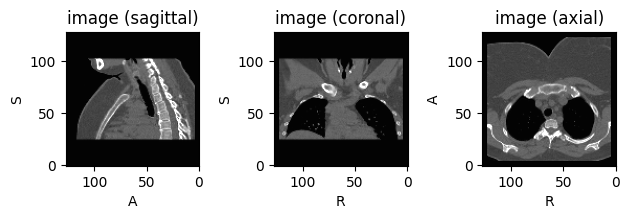

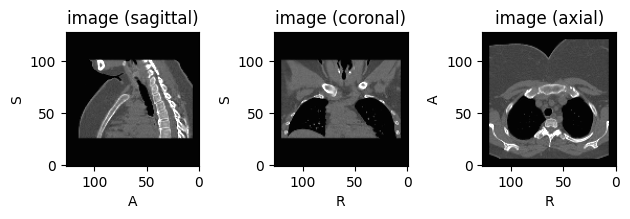

(1, 128, 128, 128) (1, 128, 128, 128)


In [14]:
image = tio.ScalarImage('E:/master-thesis/preprocess/test-results/center_cropped_image_xyz.nii.gz')
subject = tio.Subject(image=image)
transform1 = RandomResizedCrop(128)
transformed1 = transform1(subject)
transformed_image1 = transformed1['image']
# save the transformed image to a nii file
transformed_image1.save('E:/master-thesis/preprocess/test-results/demo-v2-xyz1.nii.gz')
transformed1.plot()

transform2 = RandomResizedCrop(128)
transformed2 = transform2(subject)
transformed_image2 = transformed2['image']
# save the transformed image to a nii file
transformed_image2.save('E:/master-thesis/preprocess/test-results/demo-v2-xyz2.nii.gz')
transformed2.plot()

print(transformed_image1.shape, transformed_image2.shape)

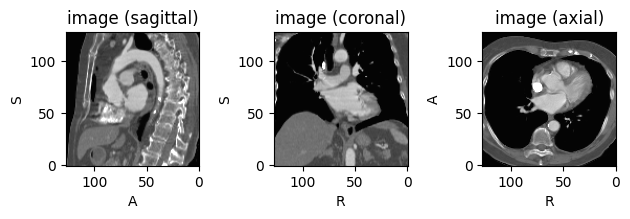

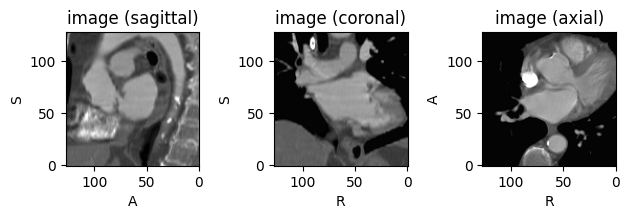

(1, 128, 128, 128) (1, 128, 128, 128)


In [56]:
image1 = tio.ScalarImage('E:/master-thesis/preprocess/test-results/center_cropped_image_z_most_common.nii.gz')
subject1 = tio.Subject(image=image1)
transform3 = RandomResizedCrop(128)
transformed3 = transform(subject1)
transformed_image3 = transformed3['image']
# save the transformed image to a nii file
transformed_image3.save('E:/master-thesis/preprocess/test-results/demo-v2-z_most_common1.nii.gz')
transformed3.plot()

transform4 = RandomResizedCrop(128)
transformed4 = transform(subject1)
transformed_image4 = transformed4['image']
# save the transformed image to a nii file
transformed_image4.save('E:/master-thesis/preprocess/test-results/demo-v2-z_most_common2.nii.gz')
transformed4.plot()

print(transformed_image3.shape, transformed_image4.shape)

### V3 - RandomResizedCrop In Use

The correct way mentioned by my supervisor is as follows:
- randomly choose the center of the patch, a.k.a., (x, y, z) uniformly sampled from the range of (0, 320) for each dimension;
- randomly generate the height, width, and depth of the 3D box with the center (x, y, z). The generated box takes the portion of the original image with the area of (25% ~ 100%);
- resample the patch to the target size of $128\times 128 \times 128$ using interpolation.

Update: By the meeting on April 17, my supervisor told me that the resized size should not be scaled in 2 times of the original image, 2x bigger or smaller. Therefore, the sampling factor is computed as $1/x^3 = 2 \Rightarrow x = 2^{-1/3} \approx 0.7937$. The resampling factor should be in the range of $(0.7937, 1.0)$. However, for the smaller, since we dont want to include any empty or useless values inside, the range should be $(0.7937, 1.0)$.

Regarding the target output shape, it will be decided by computation power whether it is $128\times 128 \times 128$ or $64\times 64 \times 64$.


#### Entire V3

In [17]:
def drop_invalid_range(sitk_image):
    # drop invalid slices, where slice only contains 1 single value
    vox = sitk.GetArrayFromImage(sitk_image)
    
    # flag: 0 -> no need to crop, 1 -> crop
    flag_z = 1 if len(np.unique(vox[0])) == 1 else 0
    flag_y = 1 if len(np.unique(vox[:, 0])) == 1 else 0
    flag_x = 1 if len(np.unique(vox[:, :, 0])) == 1 else 0
    
    if flag_z == 0 and flag_y == 0 and flag_x == 0:
        # print('No need to crop')
        return sitk_image
    
    # invalid slices where slice only contains 1 single value
    # print('Cropping')
    start_id_depth = 0
    start_id_width = 0
    start_id_height = 0
    
    end_id_depth = vox.shape[0] - 1
    end_id_width = vox.shape[2] - 1
    end_id_height = vox.shape[1] - 1
    
    for i in range(vox.shape[0]):
        if len(np.unique(vox[i])) != 1:
            start_id_depth = i
            break
        
    for i in range(vox.shape[0] - 1, -1, -1):
        if len(np.unique(vox[i])) != 1:
            end_id_depth = i
            break
        
    for i in range(vox.shape[1]):
        if len(np.unique(vox[:, i])) != 1:
            start_id_height = i
            break
    
    for i in range(vox.shape[1] - 1, -1, -1):
        if len(np.unique(vox[:, i])) != 1:
            end_id_height = i
            break
        
    for i in range(vox.shape[2]):
        if len(np.unique(vox[:, :, i])) != 1:
            start_id_width = i
            break
        
    for i in range(vox.shape[2] - 1, -1, -1):
        if len(np.unique(vox[:, :, i])) != 1:
            end_id_width = i
            break
    
    # # crop invalid slices by using crop filter
    crop_filter = sitk.CropImageFilter()
    crop_filter.SetLowerBoundaryCropSize([start_id_width, 
                                          start_id_height, 
                                          start_id_depth])
    crop_filter.SetUpperBoundaryCropSize([vox.shape[2] - 1 - end_id_width, 
                                          vox.shape[1] - 1 - end_id_height, 
                                          vox.shape[0] - 1 - end_id_depth])
    sitk_image = crop_filter.Execute(sitk_image)
    return sitk_image

def generate_random_box(sitk_image, scale=(0.25, 1.0)):
    width, height, depth = sitk_image.GetSize()
    # random size with random x, y, z
    scale_width, scale_height, scale_depth = np.random.uniform(*scale), np.random.uniform(*scale), np.random.uniform(*scale)
    width_box, height_box, depth_box = int(scale_width*width), int(scale_height*height), int(scale_depth*depth)
    # randomly generate the start position of the box
    start_width, start_height, start_depth = np.random.randint(0, width - width_box), np.random.randint(0, height - height_box), np.random.randint(0, depth - depth_box)
    # use the box to crop the original image
    crop_filter = sitk.CropImageFilter()
    crop_filter.SetLowerBoundaryCropSize([start_width, start_height, start_depth])
    crop_filter.SetUpperBoundaryCropSize([width - width_box - start_width, 
                                          height - height_box - start_height, 
                                          depth - depth_box - start_depth])
    cropped = crop_filter.Execute(sitk_image)
    return cropped

# apply resample filter to the cropped image to the fixed shape of (128, 128, 128)
def resample2target(sitk_image, new_size=(64, 64, 64), interpolation=sitk.sitkBSpline):
    # original spacing
    original_spacing = sitk_image.GetSpacing()
    original_size = sitk_image.GetSize()
    ratio = [sz/nsz for sz, nsz in zip(original_size, new_size)]
    # new spacing
    new_spacing = [osz*rsz for osz, rsz in zip(original_spacing, ratio)]
    # resample filter
    resample_filter = sitk.ResampleImageFilter()
    resample_filter.SetOutputSpacing(new_spacing)
    resample_filter.SetSize(new_size)
    # interpolation method
    resample_filter.SetInterpolator(interpolation)
    resample_filter.SetOutputOrigin(sitk_image.GetOrigin())
    resample_filter.SetOutputDirection(sitk_image.GetDirection())
    resampled = resample_filter.Execute(sitk_image)
    return resampled

class RandomResizedCrop(tio.Transform):
    def __init__(self, size, scale=(0.25, 1.0)):
        super().__init__()
        self.size = self.parse_size(size)
        self.scale = scale
    
    def apply_transform(self, subject):
        # drop invalid slices
        image = subject['image']
        sitk_image = image.as_sitk()
        dropped = drop_invalid_range(sitk_image)
        cropped = generate_random_box(dropped, scale=self.scale)
        # resample the cropped image to the size
        resampled = resample2target(cropped, new_size=self.size)
        # convert the resampled image back to torchio image, from sitk
        resampled = tio.ScalarImage.from_sitk(resampled)
        subject['image'] = resampled
        return subject
    
    def parse_size(self, size):
        if isinstance(size, int):
            return (size, size, size)
        elif isinstance(size, tuple):
            return size
        else:
            raise ValueError(f'Invalid size: {size}')

#### Drop Invalid Range

Since the preprocessed image has been cropped or padded, if padded, then some parts of the image are filled with zeros, which are not interested in the training. Therefore, the function drop_invalid_range helps to drop the invalid range, 
- the padded region (slice)
- the useless region (the region without info)

Example: 
- `E:\master-thesis\methods\demo_center_cropped\LIDC-IDRI-0001_center_cropped.nii.gz`
- `E:\master-thesis\methods\drop_invalid\LIDC-IDRI-0001_center_cropped_dropped.nii.gz`

See more results in the folder `E:\master-thesis\methods\drop_invalid`.

For example, the smallest original CT with the shape of (264, 264, 166), after preprocessing, it has been padded to the shape of (320, 320, 320). For precisely cropping without including useless padding, the function drop_invalid_range helps to drop the invalid range of the image, and the shape after is (264, 264, 166), however, it is not always since the not only padding will be dropped but also the useless region without info.

In [257]:
def drop_invalid_range(sitk_image):
    # drop invalid slices, where slice only contains 1 single value
    vox = sitk.GetArrayFromImage(sitk_image)
    
    # flag: 0 -> no need to crop, 1 -> crop
    flag_z = 1 if len(np.unique(vox[0])) == 1 else 0
    flag_y = 1 if len(np.unique(vox[:, 0])) == 1 else 0
    flag_x = 1 if len(np.unique(vox[:, :, 0])) == 1 else 0
    
    if flag_z == 0 and flag_y == 0 and flag_x == 0:
        # print('No need to crop')
        return sitk_image
    
    # invalid slices where slice only contains 1 single value
    # print('Cropping')
    start_id_depth = 0
    start_id_width = 0
    start_id_height = 0
    
    end_id_depth = vox.shape[0] - 1
    end_id_width = vox.shape[2] - 1
    end_id_height = vox.shape[1] - 1
    
    for i in range(vox.shape[0]):
        if len(np.unique(vox[i])) != 1:
            start_id_depth = i
            break
        
    for i in range(vox.shape[0] - 1, -1, -1):
        if len(np.unique(vox[i])) != 1:
            end_id_depth = i
            break
        
    for i in range(vox.shape[1]):
        if len(np.unique(vox[:, i])) != 1:
            start_id_height = i
            break
    
    for i in range(vox.shape[1] - 1, -1, -1):
        if len(np.unique(vox[:, i])) != 1:
            end_id_height = i
            break
        
    for i in range(vox.shape[2]):
        if len(np.unique(vox[:, :, i])) != 1:
            start_id_width = i
            break
        
    for i in range(vox.shape[2] - 1, -1, -1):
        if len(np.unique(vox[:, :, i])) != 1:
            end_id_width = i
            break
    
    # # crop invalid slices by using crop filter
    crop_filter = sitk.CropImageFilter()
    crop_filter.SetLowerBoundaryCropSize([start_id_width, 
                                          start_id_height, 
                                          start_id_depth])
    crop_filter.SetUpperBoundaryCropSize([vox.shape[2] - 1 - end_id_width, 
                                          vox.shape[1] - 1 - end_id_height, 
                                          vox.shape[0] - 1 - end_id_depth])
    sitk_image = crop_filter.Execute(sitk_image)
    return sitk_image

##### Visualization

Cropping


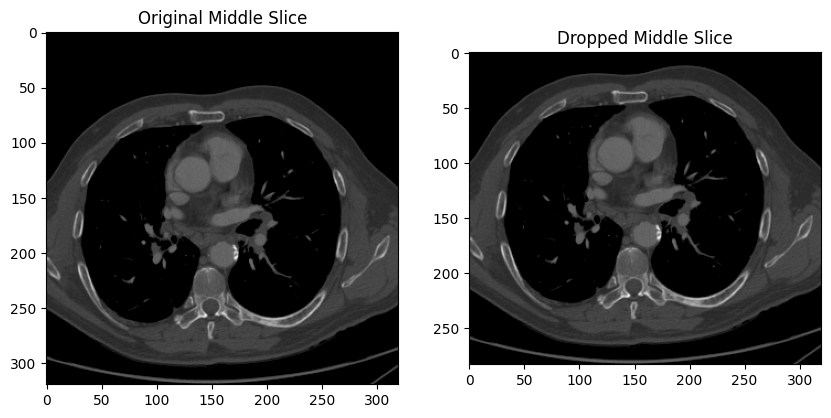

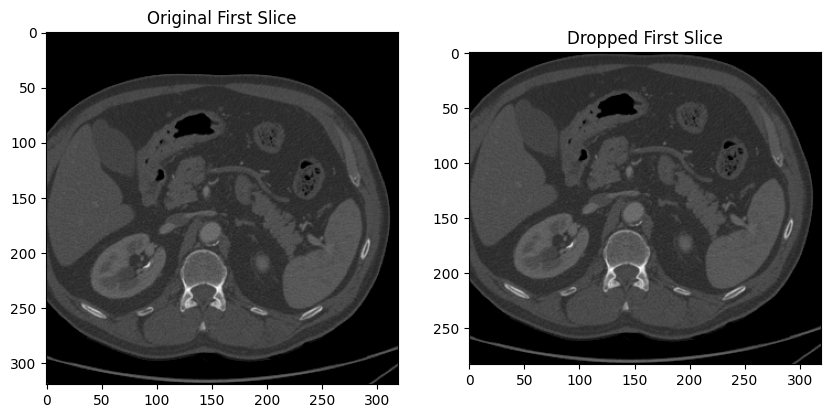

In [73]:
# E:\master-thesis\methods\demo_center_cropped\LIDC-IDRI-0005_center_cropped.nii.gz
sitk_image = sitk.ReadImage('E:/master-thesis/methods/demo_center_cropped/LIDC-IDRI-0010_center_cropped.nii.gz')
dropped = drop_invalid_range(sitk_image)
sitk.WriteImage(dropped, 'E:/master-thesis/methods/drop_invalid/LIDC-IDRI-0010_center_cropped_dropped.nii.gz')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
mid_original = sitk.GetArrayFromImage(sitk_image).shape[0] // 2
mid_dropped = dropped.GetSize()[2] // 2
ax[0].imshow(sitk.GetArrayFromImage(sitk_image)[mid_original], cmap='gray')
ax[0].set_title('Original Middle Slice')
ax[1].imshow(sitk.GetArrayFromImage(dropped)[mid_dropped], cmap='gray')
ax[1].set_title('Dropped Middle Slice')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sitk.GetArrayFromImage(sitk_image)[0], cmap='gray')
ax[0].set_title('Original First Slice')
ax[1].imshow(sitk.GetArrayFromImage(dropped)[0], cmap='gray')
ax[1].set_title('Dropped First Slice')
plt.show()

##### Drop Invalid Range with empty slice

see example in the folder `E:\master-thesis\methods\center_cropped\scan-1.nii.gz` and the folder `E:\master-thesis\methods\drop_invalid\scan-1_dropped.nii.gz`.

Handle correctly!

In [255]:
# since some 3D data could contain a empty slice on top, for instance -> E:\master-thesis\methods\center_cropped\scan-1.nii.gz
img = sitk.ReadImage('E:/master-thesis/methods/center_cropped/scan-1.nii.gz')
dropped = drop_invalid_range(img)
sitk.WriteImage(dropped, 'E:/master-thesis/methods/drop_invalid/scan-1_dropped.nii.gz')

#### Random Box 3D

This randomly generate a 3D box with a random shape with the random start point which ensures the box is within the image.

See results in the folder `E:\master-thesis\methods\random_box`

In [98]:
def generate_random_box(sitk_image, scale=(0.25, 1.0)):
    width, height, depth = sitk_image.GetSize()
    # random size with random x, y, z
    scale_width, scale_height, scale_depth = np.random.uniform(*scale), np.random.uniform(*scale), np.random.uniform(*scale)
    width_box, height_box, depth_box = int(scale_width*width), int(scale_height*height), int(scale_depth*depth)
    # randomly generate the start position of the box
    start_width, start_height, start_depth = np.random.randint(0, width - width_box), np.random.randint(0, height - height_box), np.random.randint(0, depth - depth_box)
    # use the box to crop the original image
    crop_filter = sitk.CropImageFilter()
    crop_filter.SetLowerBoundaryCropSize([start_width, start_height, start_depth])
    crop_filter.SetUpperBoundaryCropSize([width - width_box - start_width, 
                                          height - height_box - start_height, 
                                          depth - depth_box - start_depth])
    cropped = crop_filter.Execute(sitk_image)
    return cropped

##### Visualization

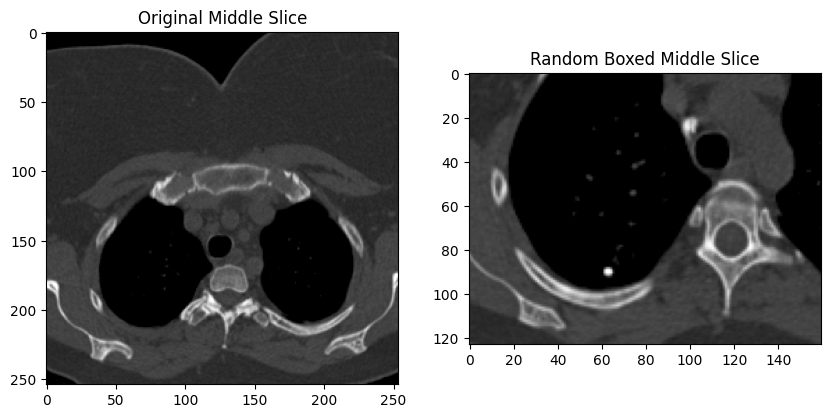

In [103]:
img = sitk.ReadImage('E:/master-thesis/methods/drop_invalid/center_cropped_image_xyz_dropped.nii.gz')
cropped = generate_random_box(img)
sitk.WriteImage(cropped, 'E:/master-thesis/methods/random_crop_box/center_cropped_image_xyz_random_box.nii.gz')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
mid_original = sitk.GetArrayFromImage(img).shape[0] // 2
mid_cropped = cropped.GetSize()[2] // 2
ax[0].imshow(sitk.GetArrayFromImage(img)[mid_original], cmap='gray')
ax[0].set_title('Original Middle Slice')
ax[1].imshow(sitk.GetArrayFromImage(cropped)[mid_cropped], cmap='gray')
ax[1].set_title('Random Boxed Middle Slice')
plt.show()

#### Resample

In [258]:
# apply resample filter to the cropped image to the fixed shape of (128, 128, 128)
def resample2target(sitk_image, new_size=(128, 128, 128), interpolation=sitk.sitkBSpline):
    # original spacing
    original_spacing = sitk_image.GetSpacing()
    original_size = sitk_image.GetSize()
    ratio = [sz/nsz for sz, nsz in zip(original_size, new_size)]
    new_spacing = [osz*rsz for osz, rsz in zip(original_spacing, ratio)] 
    # resample filter
    resample_filter = sitk.ResampleImageFilter()
    resample_filter.SetOutputSpacing(new_spacing)
    resample_filter.SetSize(new_size)
    # interpolation method
    resample_filter.SetInterpolator(interpolation)
    resample_filter.SetOutputOrigin(sitk_image.GetOrigin())
    resample_filter.SetOutputDirection(sitk_image.GetDirection())
    resampled = resample_filter.Execute(sitk_image)
    return resampled

#### Main Class - RandomResizedCrop

See demonstrations in the folder `E:\master-thesis\methods\random_resized_crop`

In [259]:
class RandomResizedCrop(tio.Transform):
    def __init__(self, size, scale=(0.25, 1.0)): # del the aspect ratio here
        super().__init__()
        self.size = self.parse_size(size)
        self.scale = scale
        # self.aspect_ratio = aspect_ratio
    
    def apply_transform(self, subject):
        # drop invalid slices
        image = subject['image']
        sitk_image = image.as_sitk()
        dropped = drop_invalid_range(sitk_image)
        cropped = generate_random_box(dropped)
        # resample the cropped image to the size of (128, 128, 128)
        resampled = resample2target(cropped)
        # convert the resampled image back to torchio image, from sitk
        resampled = tio.ScalarImage.from_sitk(resampled)
        subject['image'] = resampled
        return subject
    
    def parse_size(self, size):
        if isinstance(size, int):
            return (size, size, size)
        elif isinstance(size, tuple):
            return size
        else:
            raise ValueError(f'Invalid size: {size}')

##### Visualization

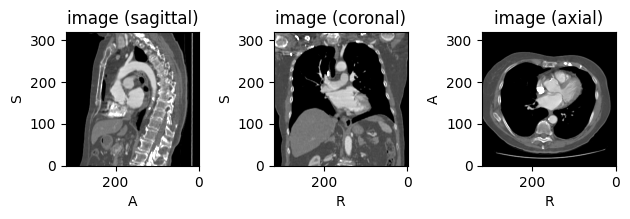

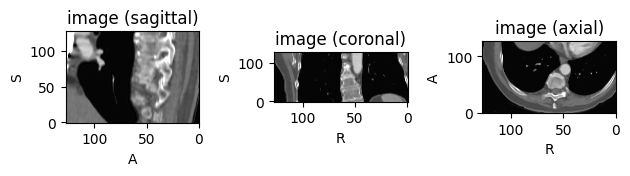

In [32]:
random_resized_crop = RandomResizedCrop(128)
demo_img = tio.ScalarImage('E:/master-thesis/preprocess/test-results/center_cropped_image_z_most_common.nii.gz')
demo_subject = tio.Subject(image=demo_img)
demo_subject.plot()
# apply the transform
transformed_subject = random_resized_crop(demo_subject)
transformed_subject.plot()
# save the transformed image to a nii file
# transformed_subject['image'].save('E:/master-thesis/methods/random_resized_crop_results/random_resized_crop_image_z_most_common.nii.gz')

## Optional Left-Right Flipping

This transform has been demonstrated in the notebook 'code.ipynb', below is the usage.

Flip probability is 0.5 for two views.

Update: By meeting April 17, this is useful for the symmetric case who may has the mirrored features, but it also hurts the performance when the model needs to distinguish the left and right side of the image. But in my case, the model does not need to recognize the left and right side of the image, so it is safe to use this augmentation.

In [29]:
optional_flip = tio.RandomFlip(axes=(0,), p=0.5)

### Visualization

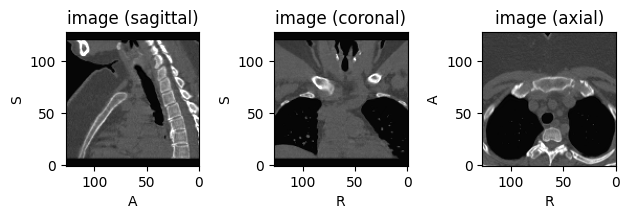

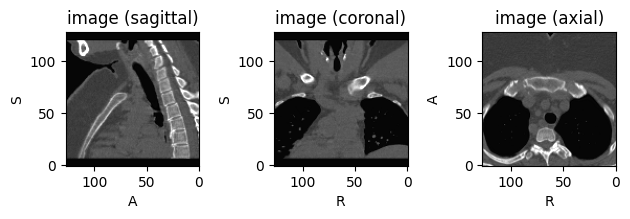

In [78]:
transformed1.plot()
flipped1 = optional_flip(transformed1)
flipped_image1 = flipped1['image']
flipped1.plot()

## Gamma Correction

This is alternative to colorjittering, which is not suitable for medical images. See details in the notebook 'code.ipynb', but use the tio.RandomGamma.

In [33]:
random_gamma = tio.RandomGamma((-2, 2), p=0.8)

### Visualization

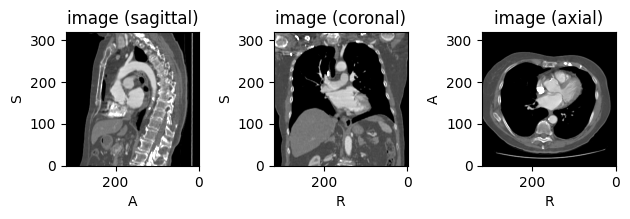

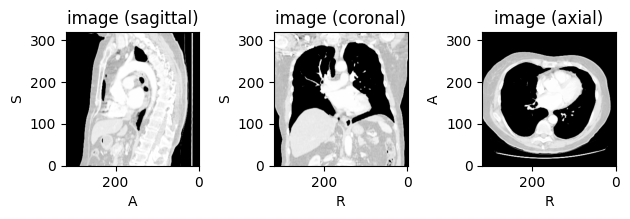

In [49]:
#'E:/master-thesis/preprocess/test-results/center_cropped_image_z_most_common.nii.gz'
tioimg = tio.Subject(image=tio.ScalarImage('E:/master-thesis/preprocess/test-results/center_cropped_image_z_most_common.nii.gz'))
tioimg.plot()
transformed = random_gamma(tioimg)
transformed.plot()

## Gaussian Blur

See details in the notebook 'code.ipynb'.

In [5]:
# in 2D pytorch, kernel size is 3 by 3, sigma is (0.1, 2.0)
blur1 = tio.RandomBlur(std=(0.1, 2.0), p=1)
blur2 = tio.RandomBlur(std=(0.1, 2.0), p=0.1)

### Visualization

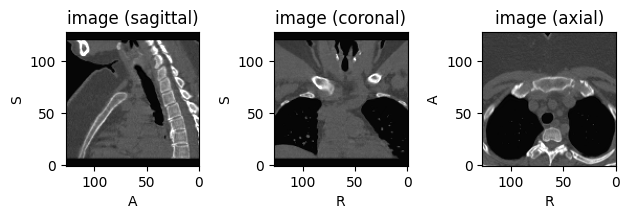

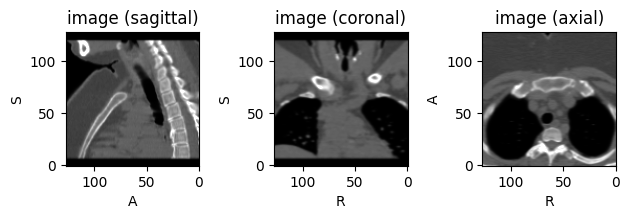

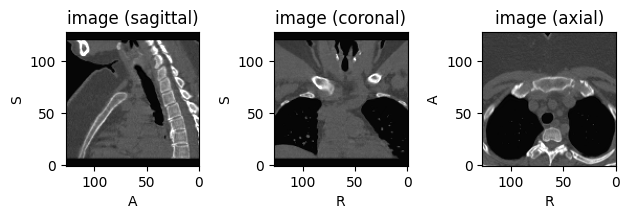

In [128]:
transformed1.plot()
blurred1 = blur1(transformed1)
blurred_image1 = blurred1['image']
blurred1.plot()
blurred2 = blur2(transformed1)
blurred_image2 = blurred2['image']
blurred2.plot()

## Normalization

This is the last step of the data augmentation, which is to normalize the image to the range of [0, 1].

Update: By meeting April 17, the normalization should be in the range of [-1, 1] for the BYOL method, and the reason is that most activation functions will make the model do not learn something when the input is mapped into the zero zone, for instance, ReLU. If the negative input comes to the ReLU, it will be mapped to negative part with the slope (gradient) to zero, which is not good for the learning. Therefore, the normalization should be in the range of [-1, 1].

In [6]:
normalizer = tio.RescaleIntensity((0, 1))

### Visualization

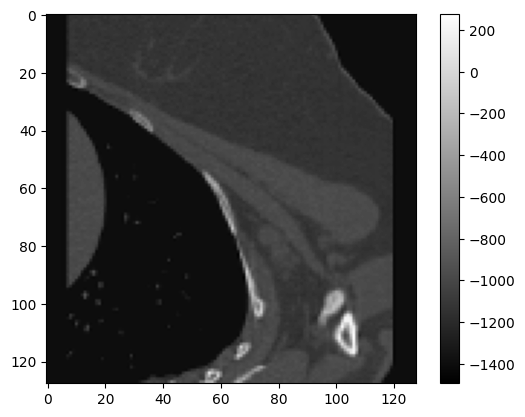

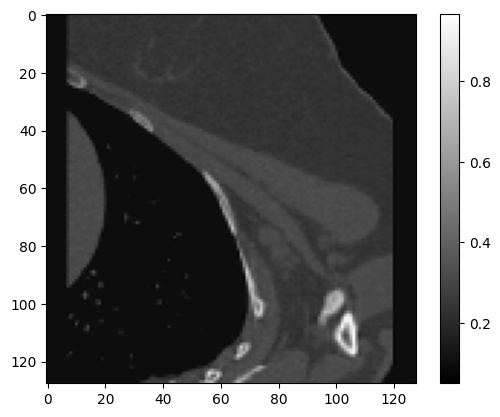

In [142]:
img = transformed1['image']
plt.imshow(img.data[0, 10, :, :], cmap='gray')
plt.colorbar()
plt.show()
normalized1 = normalizer(transformed1)
plt.imshow(normalized1['image'].data[0, 10, :, :], cmap='gray')
plt.colorbar()
plt.show()

## Demo with Series of Augmentations

In [18]:
import torch

In [23]:
DEFAULT_AUG = tio.Compose([
            # randomresizedcrop
            RandomResizedCrop(size=(64, 64, 64)),
            # randomflip
            tio.RandomFlip(axes=(0,), p=0.5),
            # random gamma
            tio.RandomGamma((-2, 2), p=0.4),
            # random blur: view 1 p=0.2, view 2 p=1
            tio.RandomBlur(std=(0.1, 2.0), p=0.2),
            # normalize
            tio.RescaleIntensity((-1, 1)),
        ])

In [5]:
# tio.Subject: create subjects which stored in the folder: E:\master-thesis\methods\demo_center_cropped
folder_path = 'E:/master-thesis/methods/demo_center_cropped'
pids = ['LIDC-IDRI-{:04d}'.format(i+1) for i in range(10)]
suffix = '_center_cropped.nii.gz'
subjects = []
for pid in pids:
    image_path = folder_path + '/' + pid + suffix
    subject = tio.Subject(
        image=tio.ScalarImage(image_path)
    )
    subjects.append(subject)
    
# create dataset
dataset = tio.SubjectsDataset(subjects)
# training loader
training_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
)
for i, batch in enumerate(training_loader):
    # check the shape of the batch
    print(batch['image']['data'].shape)
    # images
    images = batch['image']['data']

torch.Size([2, 1, 320, 320, 320])
torch.Size([2, 1, 320, 320, 320])
torch.Size([2, 1, 320, 320, 320])
torch.Size([2, 1, 320, 320, 320])
torch.Size([2, 1, 320, 320, 320])


In [24]:
augmentation1 = DEFAULT_AUG
augmentation2 = DEFAULT_AUG

### Process in Method

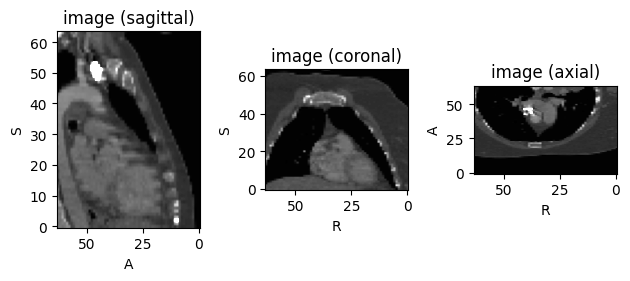

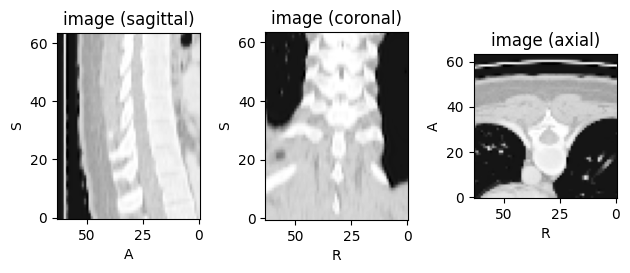

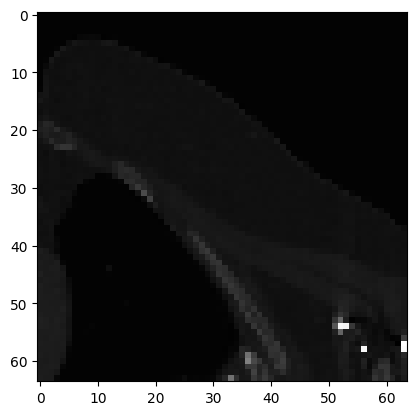

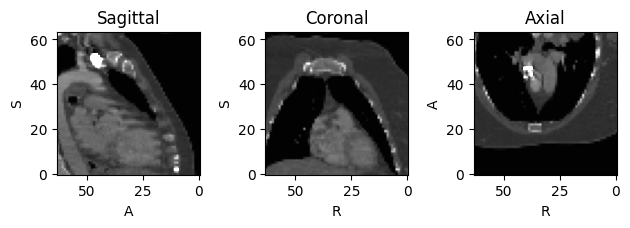

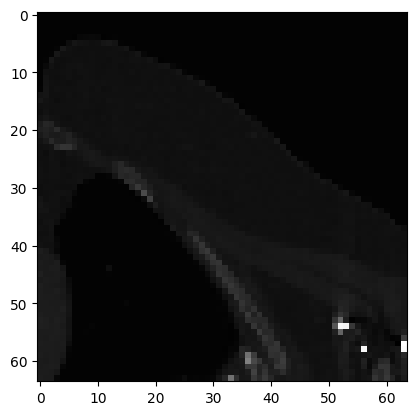

torch.Size([4, 1, 64, 64, 64])


In [27]:
# get the first batch
batch = next(iter(training_loader))
for i, batch in enumerate(training_loader):
    images = batch['image']['data']
    subjects = [tio.Subject(image=tio.ScalarImage(tensor=images[i])) for i in range(images.shape[0])]

    first_augmented_two_views = [augmentation1(subject) for subject in subjects]
    second_augmented_two_views = [augmentation2(subject) for subject in subjects]
    
    first_augmented_two_views[0].plot()

    subjects[0]['image'].save('E:/master-thesis/methods/augmented_results/original_image-64.nii.gz')
    first_augmented_two_views[0]['image'].save('E:/master-thesis/methods/augmented_results/first_augmented_two_views-64.nii.gz')
    second_augmented_two_views[0].plot()
    # SAVE
    second_augmented_two_views[0]['image'].save('E:/master-thesis/methods/augmented_results/second_augmented_two_views-64.nii.gz')
    plt.imshow(first_augmented_two_views[0]['image'].data[0, 10, :, :], cmap='gray')
    plt.show()
    
    # image_one = torch.stack([subject['image'][tio.DATA] for subject in first_augmented_two_views])
    # image_two = torch.stack([subject['image'][tio.DATA] for subject in second_augmented_two_views])
    # the code above is deprecated since it only retains the image info, not the subject info like affine
    # the code below is the correct way to stack the images
    image_one = torch.stack([subject['image'].tensor for subject in first_augmented_two_views])
    image_two = torch.stack([subject['image'].tensor for subject in second_augmented_two_views])
    
    tio.ScalarImage(tensor=image_one[0]).plot()
    plt.imshow(image_one[0][0, 10, :, :], cmap='gray')
    plt.show()

    
    images = torch.cat([image_one, image_two], dim=0)
    print(images.shape)
    break